# Imports

In [1]:
import requests, zipfile, io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('adornmyplot.mplstyle')
import matplotlib as mpl

import pyvista as pv

import mmt_dipole_cuboid_inversion as dci
import mmt_dipole_cuboid_inversion.tools as dcit

import mmt_multipole_inversion as minv
import json

# Data

We start downloading the data of de Groot et al. (2018)\* from the public repository PANGAEA. The updated version of the data contains three areas that are pre-processed and where tomography and magnetometry coordinates are co-registered. We unzip the data and extract the contents.

*de Groot, L.V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H., 2018. List of grains and results of the Scanning SQUID Magnetometer (SSM) scan. URL: https://doi.org/10.1594/PANGAEA.886724*

*de Groot, L.V., Fabian, K., Béguin, A., Reith, P., Barnhoorn, A., Hilgenkamp, H., 2018. Determining Individual Particle Magnetizations in Assemblages of Micrograins. Geophysical Research Letters 45, 2995–3000. URL: https://agupubs.onlinelibrary.wiley.com/doi/478*

In [2]:
# DATA ------------------------------------------------------------------------

# Download the data to this directory:
data_dir = Path('deGroot2018_data')
data_dir.mkdir(exist_ok=True)

if not any(data_dir.iterdir()):
    data_url = 'https://store.pangaea.de/Publications/deGroot-etal_2018/Micro-grain-data.zip'
    r = requests.get(data_url)
    # Pass the request output `r` (in byte-like format) to get a binary stream
    # from a data piece in memory (buffer) using BytesIO -> like a file in mem
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(data_dir)

    # Now open the ZIP file with formatted data:
    z = zipfile.ZipFile(data_dir / 'V2_2021-04.zip')
    z.extractall(data_dir)

The following are the magnetization values reported by (de Groot et al., 2018), for the grains in Area 3 with unknown magnetizations:

In [3]:
dG_Area3UMS = np.array([2648.9, 17527.8, 5667.3, 11663.0, 4285.6, 8104.8])
dG_Area3UMS_m = np.array([(-537.6, 2563.2, 397.3), (4329.4, -265.3, -16982.6), 
                          (-5645.3, 104.6, -487.3), (-10400.4, -3218.6, -4183.0),
                          (3096.3, -2087.5, 2102.8), (-717.6, 554.0, -8053.9)])

# Compute the angles from dG's magnetizations
m = np.copy(dG_Area3UMS_m)
phi = np.arctan2(m[:, 1], m[:, 0])  # arctan(y / x)
theta = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))  # arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)

dG_Area3UMS_anglesNew = np.column_stack((np.rad2deg(phi), np.rad2deg(theta)))
dG_Area3UMS_anglesNew[:, 0][dG_Area3UMS_anglesNew[:, 0] < 0] += 360
ftr = np.logical_and(dG_Area3UMS_anglesNew[:, 1] >= 0, dG_Area3UMS_anglesNew[:, 1] <= 180)
dG_Area3UMS_anglesNew[:, 1][ftr] -= 90
dG_Area3UMS_anglesNew[:, 1][ftr] *= -1

In [4]:
print('Corrected angles from de Groot (2018) (z-axis towards depth):')
with np.printoptions(suppress=True):
    print(dG_Area3UMS_anglesNew)

Corrected angles from de Groot (2018) (z-axis towards depth):
[[101.84539146   8.62604683]
 [356.493374   -75.67240871]
 [178.93850587  -4.93267683]
 [197.1956684  -21.01768362]
 [326.0124749   29.38427814]
 [142.33121907 -83.57767001]]


# Visualize grains

In this section we make a visualization of the tomographic data. Tomography voxels are already aggregated into the largest possible cuboids using the `cuboid_aggregation` algorithm included in the `mmt_dipole_cuboid_inversion` library. The visualization is done using the PyVista library.
* Notice that the `CuboidFile` in this case has an extra row that we must skip

In [6]:
data_dir = Path('deGroot2018_data/PDI-16803')
# Location and name of QDM and cuboid file
ScanFile = data_dir / 'Area3-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A3.txt'
cuboid_data = np.loadtxt(CuboidFile, skiprows=1)
cuboid_data[:, 2] *= -1
idxs = cuboid_data[:, 6].astype(np.int16)

In [7]:
print('Cuboid data example: x y z dx dy dz index')
print(cuboid_data[:2, :])

Cuboid data example: x y z dx dy dz index
[[ 59.88 188.88 -11.     3.96   3.96   6.6    1.  ]
 [ 61.2  183.6   -9.68   2.64   1.32   7.04   1.  ]]


In [8]:
# Make a block of data from every cuboid, for every particle; to plot the cuboids
block = pv.MultiBlock()
# g_idx = 1
for g_idx in range(1, len(np.unique(idxs)) + 1):  # for every particle
    for cuboid in cuboid_data[idxs == g_idx]:  # for each of its cuboids
        # remember dx dy dz are half-lengths so we multiply by 2 to get cuboid extents:
        c = pv.Cube(center=cuboid[:3], x_length=2*cuboid[3], y_length=2*cuboid[4], z_length=2*cuboid[5])
        c.cell_data['Gindex'] = [g_idx for i in range(6)]  # 
        block.append(c)

block = block.combine()

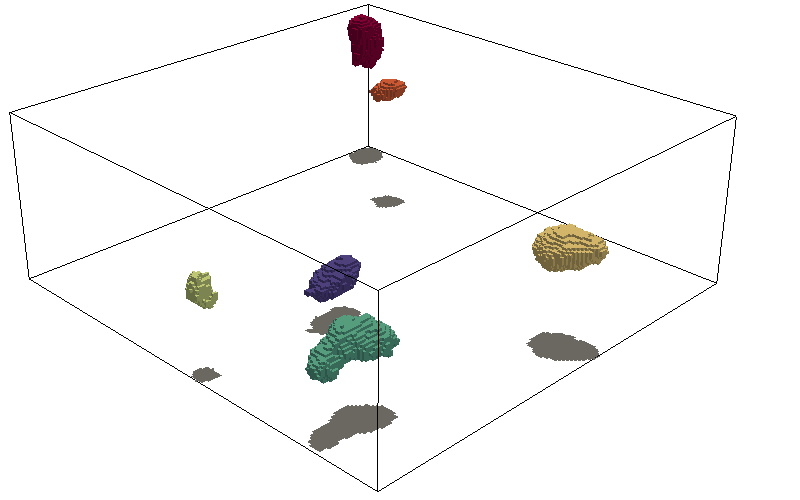

In [9]:
pV = pv.Plotter(off_screen=False, notebook=True, window_size=[800, 500])
pV.set_background('white')

pV.add_mesh(block, scalars='Gindex', smooth_shading=False, show_scalar_bar=False,
            cmap='spectral')
# print (f"Loading mesh: {perf_counter() - t2}")

# Make the sample outline
box_lim = 0.17
box = pv.Box([cuboid_data[:, 0].min(), cuboid_data[:, 0].max(),
              cuboid_data[:, 1].min(), cuboid_data[:, 1].max(),
              cuboid_data[:, 2].min() - 10, 0.0])
pV.add_mesh(box.outline(), color='black', opacity=1, line_width=1)

# Make the grain shadows
pV.add_mesh(
    block.extract_geometry().project_points_to_plane(origin=(0, 0, cuboid_data[:, 2].min() - 10), 
                                                     normal=(0, 0, 1)),
                                                     opacity=1, style='surface', color='grey')
pV.view_isometric()
pV.camera.SetWindowCenter(0.07, -0.2)
pV.camera.zoom(1.5)
pV.camera.azimuth = -90
pV.camera.elevation = -10

pV.show(jupyter_backend='static')

# Dipole Cuboid Inversion

In this section we apply the homogeneously magnetized particle model to do the inversions. This means cuboids are asumed uniformly magnetized and we obtain dipole order solutions from the inversions.

In [11]:
data_dir = Path('deGroot2018_data/PDI-16803')

# location and name of QDM and cuboid file
ScanFile = data_dir / 'Area3-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A3.txt'

cub_data = np.loadtxt(CuboidFile, skiprows=1)
cub_data[:, 2] *= -1

SQUID_sensor_domain = np.array([[0, 0], [350, 200]]) * 1e-6
SQUID_spacing = 1e-6
SQUID_deltax = 0.5e-6
SQUID_deltay = 0.5e-6
SQUID_area = 1e-12
scan_height = 2e-6

mag_inv = dci.DipoleCuboidInversion(None, SQUID_sensor_domain, SQUID_spacing,
        SQUID_deltax, SQUID_deltay, SQUID_area, scan_height, verbose=True)

mag_inv.read_files(ScanFile, cub_data, cuboid_scaling_factor=1e-6)
mag_inv.set_scan_domain(gen_sd_mesh_from='sensor_center_domain')

# We then compute the forward (Green's) matrix that we use to invert the scan field:
mag_inv.prepare_matrix(method='cython')

# And we do the inversion:
mag_inv.calculate_inverse(method='scipy_pinv', rtol=1e-30)

Domain limit 0 has been reset from 0.00035 to 0.000249.
Domain limit 1 has been reset from 0.00019999999999999998 to 0.000249.
Start inversion with 62500 knowns and 18 unknowns
Inversion has been carried out


In [12]:
mag_dpinv = np.linalg.norm(mag_inv.Mag.reshape(-1, 3), axis=1)

In [13]:
print('Dipole cuboid inversion code - Magnetic moments:')
print(mag_dpinv)

Dipole cuboid inversion code - Magnetic moments:
[ 2521.91211227 17274.42171778  5636.22540543 11613.46536364
  4268.19001189  8057.23271975]


In [14]:
print('Dipole cuboid inversion code - Magnetizations:')
mag_inv.Mag.reshape(-1, 3)

Dipole cuboid inversion code - Magnetizations:


array([[  -524.39126631,   2437.06460527,   -381.79917703],
       [  4343.52768431,   -298.72777503,  16716.76328288],
       [ -5614.58828478,    104.11545076,    482.28123134],
       [-10364.47423898,  -3184.25276704,   4160.62324869],
       [  3078.47079496,  -2080.5647117 ,  -2100.40806097],
       [  -668.31808925,    573.67131684,   8008.94819886]])

In [15]:
# Compute spherical angles:
# array with the magnetizations. It's the same if we use normalized m
m = np.copy(mag_inv.Mag.reshape(-1, 3))
# mnorm = m / np.linalg.norm(m, axis=1)[:, np.newaxis]
phi = np.arctan2(m[:, 1], m[:, 0])  # arctan(y / x) for every row (particle)
theta = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))  # arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)

# Convert to degrees and correct angles: polar angles measured from equator and
# azimuthal angles in [0,360] degrees range
angles_dpinv = np.column_stack((np.rad2deg(phi), np.rad2deg(theta)))
angles_dpinv[:, 0][angles_dpinv[:, 0] < 0] += 360
ftr = np.logical_and(angles_dpinv[:, 1] >= 0, angles_dpinv[:, 1] <= 180)
angles_dpinv[:, 1][ftr] -= 90
angles_dpinv[:, 1][ftr] *= -1

In [16]:
print('Dipole cuboid inversion code - Angles:')
angles_dpinv

Dipole cuboid inversion code - Angles:


array([[102.14337122,  -8.70764633],
       [356.0656563 ,  75.40193402],
       [178.93764387,   4.90869497],
       [197.07840389,  20.993286  ],
       [325.94745845, -29.47919187],
       [139.35784683,  83.72424817]])

In [17]:
# Compute the volumes of the grains by summing its cuboid components
cuboidVols = np.zeros(8)
cuboidIdxs = cuboid_data[:, 6].astype(np.int16)
vols = 8 * cub_data[:, 3] * cub_data[:, 4] * cub_data[:, 5]
for i, particle_idx in enumerate(np.unique(cuboidIdxs)):
    p = cuboidIdxs == particle_idx
    cuboidVols[i] = vols[p].sum()

cuboidDepths = cub_data[:, 2] * (-1)

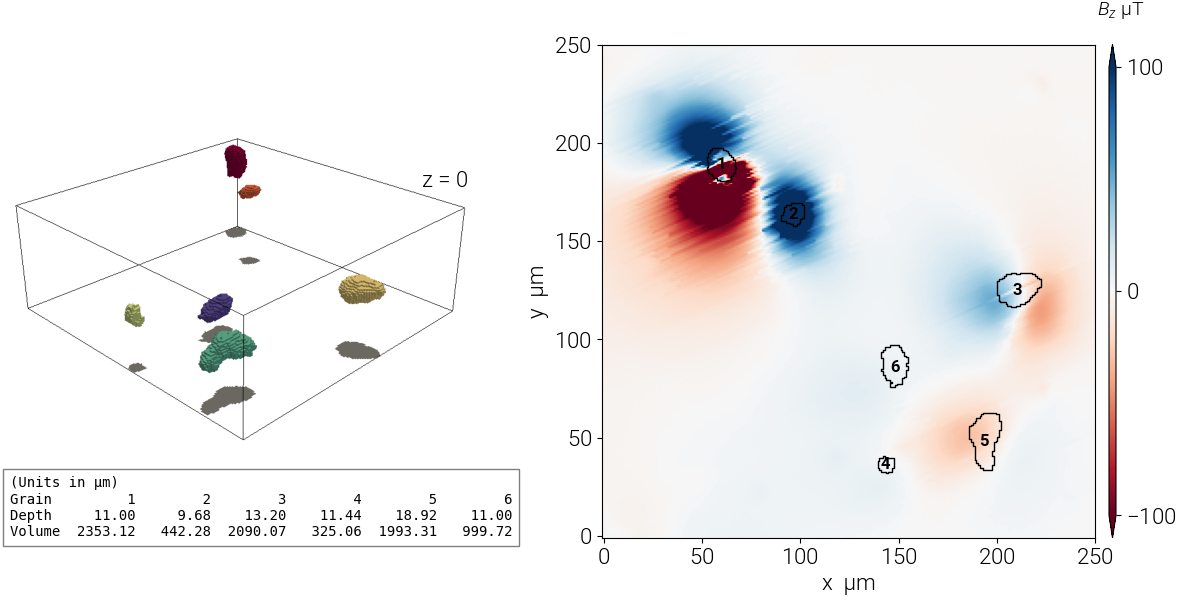

In [18]:
dcit.plot.set_grain_geometries(mag_inv, spatial_scaling=1e6)

f, axs = plt.subplots(ncols=2, figsize=(14, 8))

axs[0].imshow(pV.image)
axs[0].set_axis_off()
axs[0].text(0.93, 0.89, 'z = 0', va='top', ha='right',
            color='k', fontsize=16, transform=axs[0].transAxes)


# vlim = np.max(np.abs(mag_inv.scan_matrix / mag_inv.scan_area)) * 1e6
vlim = 100
dcit.plot.plot_grain_boundaries(mag_inv, axs[1], 
                                labels_args=dict(ha='center', va='center', fontsize=12, fontweight=600))
im = dcit.plot.plot_scan_field(mag_inv, axs[1], scale_field=1e6 / mag_inv.scan_area,
                               imshow_args=dict(cmap='RdBu', vmin=-vlim, vmax=vlim))
axs[1].set_xlabel('x  µm')
axs[1].set_ylabel('y  µm')

# COLORBAR
axL = axs[1].get_position()
axcb = f.add_axes([axL.x1 + 0.01, axL.y0, 0.005, axL.height])
cb = f.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-vlim, vmax=vlim), cmap='RdBu'), 
                cax=axcb, orientation='vertical', # shrink=0.7, aspect=10, # pad=-0.8
                extend='both')
cb.ax.xaxis.set_ticks_position('top')
cb.set_ticks((-vlim, 0, vlim))
cb.set_label(r'$B_{z}$' + ' µT', fontsize=14, y=1.15, rotation=0, labelpad=-40)

depthLab = '(Units in µm)\n'
depthLab += 'Grain '
for i in range(len(np.unique(cuboidIdxs))):
    depthLab += f'{i + 1:>9}'
depthLab += '\nDepth '
for i in range(len(np.unique(cuboidIdxs))):
    depthLab += f'{cuboidDepths[i]:>9.2f}'

depthLab += '\nVolume'
for i in range(len(np.unique(cuboidIdxs))):
    depthLab += f'{cuboidVols[i]:>9.2f}'

axs[0].text(0., -0.1, depthLab, va='top', ha='left',
            color='k', fontsize=10, fontfamily='monospace',
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5},
            transform=axs[0].transAxes)


plt.savefig('figures/area3_degroot18_overview.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [19]:
print(depthLab)

(Units in µm)
Grain         1        2        3        4        5        6
Depth     11.00     9.68    13.20    11.44    18.92    11.00
Volume  2353.12   442.28  2090.07   325.06  1993.31   999.72


# Multipole Inversion

In this section we apply the multipole expansion model for the inversions, thus we use the `mmt_multipole_inversion library`. Start by computing the particle centers from the tomography/cuboids data:

In [21]:
# -----------------------------------------------------------------------------
# DEFINE PARTICLES

data_dir = Path('deGroot2018_data/PDI-16803')

# Location and name of QDM and cuboid file
ScanFile = data_dir / 'Area3-90-fig2MMT.txt'
CuboidFile = data_dir / 'FWInput-FineCuboids-A3.txt'
# Load center and half lengths of cuboids making the grains (tomog data)
cuboid_data = np.loadtxt(CuboidFile, skiprows=1)
# x, y = np.copy(cuboid_data[:, 0]), np.copy(cuboid_data[:, 1])
# cuboid_data[:, 0] = y
# cuboid_data[:, 1] = x
cuboid_data[:, 2] *= -1

cuboid_data_idxs = cuboid_data[:, 6].astype(np.int16)
cx, cy, cz, cdx, cdy, cdz = (cuboid_data[:, i] for i in range(6))
vols = 8 * cdx * cdy * cdz

# Compute centers of mass (geometric centre) per p. into the particles array
particles = np.zeros((len(np.unique(cuboid_data_idxs)), 4))
centre = np.zeros(3)
for i, particle_idx in enumerate(np.unique(cuboid_data_idxs)):

    p = cuboid_data_idxs == particle_idx
    particle_vol = vols[p].sum()
    centre[0] = np.sum(cx[p] * vols[p]) / particle_vol
    centre[1] = np.sum(cy[p] * vols[p]) / particle_vol
    centre[2] = np.sum(cz[p] * vols[p]) / particle_vol

    particles[i][:3] = centre
    particles[i][3] = particle_vol

Now we define the sample:

In [22]:
# Get the dimensions of the magnetometry scan:
scan_area = np.shape(np.loadtxt(data_dir / 'Area3-90-fig2MMT.txt'))
# N particles:
Nparticles = len(np.unique(cuboid_data_idxs))

In [23]:
# -----------------------------------------------------------------------------
# DEFINE SAMPLE

# Directory to save the files
BASE_DIR = Path('SyntheticSampleFiles')
BASE_DIR.mkdir(exist_ok=True)

# Scale the positions and columes by micrometres
np.savez(BASE_DIR / 'Area3_UMS_NPZ_ARRAYS',
         # Bz_array=,
         particle_positions=particles[:, :3] * 1e-6,
         # magnetization=self.magnetization,
         volumes=particles[:, 3] * 1e-18)

# Set dictionary with scanning surface parameters
metadict = {}
metadict["Scan height Hz"] = 2e-6
metadict["Scan area x-dimension Sx"] = scan_area[1] * 1e-6
metadict["Scan area y-dimension Sy"] = scan_area[0] * 1e-6
metadict["Scan x-step Sdx"] = 1e-6
metadict["Scan y-step Sdy"] = 1e-6
metadict["Time stamp"] = '0000'
metadict["Number of particles"] = Nparticles
# Important!:
metadict["Sensor dimensions"] = (0.5e-6, 0.5e-6)

# Save dictionary into json file
with open(BASE_DIR / "AREA3_UMS_METADICT.json", 'w') as f:
    json.dump(metadict, f)

And, finally, we make the inversions using a 2D model for the magnetometer sensors. This is useful to compare the solutions against the HMP model:

In [24]:
# -----------------------------------------------------------------------------
# INVERSION

inv_area3_ums = minv.MultipoleInversion(
        BASE_DIR / "AREA3_UMS_METADICT.json",
        BASE_DIR / 'Area3_UMS_NPZ_ARRAYS.npz',
        expansion_limit='dipole',
        sus_functions_module='spherical_harmonics_basis_area')
# inv_area3_ums.sensor_dims = ()
# Load the scanning array manually:
inv_area3_ums.Bz_array = np.loadtxt(data_dir / 'Area3-90-fig2MMT.txt')

mag_minv_raw = {}
mag_minv = {}
angles_minv = {}
angles_minv_raw = {}
berr_minv = {}

for exp_limit in ['dipole', 'quadrupole']:
# for exp_limit in ['dipole']:
    inv_area3_ums.expansion_limit = exp_limit
    inv_area3_ums.compute_inversion(method='sp_pinv', rtol=1e-30)
    # inv_area3_ums.compute_inversion(rcond=1e-30, method='np_pinv')
    
    # print(inv_area3_ums.inv_multipole_moments[:, :3] / inv_area3_ums.volumes[:, None])
    
    # Compute magnetizations:
    mag = inv_area3_ums.inv_multipole_moments[:, :3] / inv_area3_ums.volumes[:, None]
    mag_area3_ums = np.sqrt(np.sum(mag ** 2, axis=1))
    
    mag_minv_raw[exp_limit] = inv_area3_ums.inv_multipole_moments[:, :3]
    
    # Compute spherical angles:
    m = mag / np.linalg.norm(m, axis=1)[:, None]  # normalized mag

    # phi = arctan(y / x)
    phi_area3_ums = np.arctan2(m[:, 1], m[:, 0])
    # theta = arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)
    theta_area3_ums = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))
 
    mag_minv[exp_limit] = mag_area3_ums
    angles_minv[exp_limit] = np.column_stack((np.rad2deg(phi_area3_ums),
                                              np.rad2deg(theta_area3_ums)))
   
    angles_minv[exp_limit][:, 0][angles_minv[exp_limit][:, 0] < 0] += 360
    ftr = np.logical_and(angles_minv[exp_limit][:, 1] >= 0, angles_minv[exp_limit][:, 1] <= 180)
    angles_minv[exp_limit][:, 1][ftr] -= 90
    angles_minv[exp_limit][:, 1][ftr] *= -1
    
    angles_minv_raw[exp_limit] = np.column_stack((np.rad2deg(phi_area3_ums),
                                                  np.rad2deg(theta_area3_ums)))
    
    berr_minv[exp_limit] = np.linalg.norm(inv_area3_ums.inv_Bz_array - inv_area3_ums.Bz_array)
    berr_minv[exp_limit] /= np.linalg.norm(inv_area3_ums.Bz_array)

*Bz_array* array required for calculations.  Set manually.
Parameter Sensor origin x not found in json file
Setting Sensor origin x value to 0.0
Parameter Sensor origin y not found in json file
Setting Sensor origin y value to 0.0
Scanning array size = 250 x 250
Generating forward matrix
Generation of Q matrix took: 9.6347 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 1.5309 s
Using scipy.linalg.pinv for inversion


In [25]:
print('Multipole inversion code - Magnetizations:')
print(mag_minv)

Multipole inversion code - Magnetizations:
{'dipole': array([ 3214.16210836, 16754.48836857,  5366.41189389, 11818.92288584,
        4015.63418375,  7940.56127098]), 'quadrupole': array([ 6430.64635974, 29603.06399823,  5075.88441074, 53167.19261219,
        7854.03677639, 58706.3143584 ])}


In [26]:
print('Multipole inversion code - Magnetizations:')
print(angles_minv['dipole'])

Multipole inversion code - Magnetizations:
[[ 99.67162982  -7.56466872]
 [358.61075358  77.36895754]
 [178.4431213    4.7982382 ]
 [193.56481914  23.29823908]
 [326.63805246 -28.30425382]
 [123.01271714  75.07893077]]


In [27]:
print('Multipole inversion code - Angles:')
angles_minv

Multipole inversion code - Angles:


{'dipole': array([[ 99.67162982,  -7.56466872],
        [358.61075358,  77.36895754],
        [178.4431213 ,   4.7982382 ],
        [193.56481914,  23.29823908],
        [326.63805246, -28.30425382],
        [123.01271714,  75.07893077]]),
 'quadrupole': array([[ 92.59110989,  -5.491412  ],
        [  1.98522689,  63.98544417],
        [162.50071225,  -2.57594312],
        [210.45222776, -43.39814018],
        [301.24958594, -54.77477565],
        [321.00792729,  54.16303555]])}

## Multipole Inversion: Point Source

Here we perform multipole inversions but modelling the sensors as point sources (for comparison)

In [28]:
# -----------------------------------------------------------------------------
# INVERSION

inv_area3_ums = minv.MultipoleInversion(
        BASE_DIR / "AREA3_UMS_METADICT.json",
        BASE_DIR / 'Area3_UMS_NPZ_ARRAYS.npz',
        expansion_limit='dipole',
        sus_functions_module='spherical_harmonics_basis')
inv_area3_ums.sensor_dims = ()
# Load the scanning array manually:
inv_area3_ums.Bz_array = np.loadtxt(data_dir / 'Area3-90-fig2MMT.txt')

mag_minv_ps = {}
angles_minv_ps = {}
angles_minv_ps_raw = {}

for exp_limit in ['dipole', 'quadrupole', 'octupole']:
# for exp_limit in ['dipole']:
    inv_area3_ums.expansion_limit = exp_limit
    inv_area3_ums.compute_inversion(method='sp_pinv', rtol=1e-30)
    # inv_area3_ums.compute_inversion(rcond=1e-30, method='np_pinv')
    
    # print(inv_area3_ums.inv_multipole_moments[:, :3] / inv_area3_ums.volumes[:, None])
    
    # Compute magnetizations:
    mag = inv_area3_ums.inv_multipole_moments[:, :3] / inv_area3_ums.volumes[:, None]
    mag_area3_ums = np.sqrt(np.sum(mag ** 2, axis=1))
    
    # Compute sph angles:
    m = mag / np.linalg.norm(m, axis=1)[:, None]

    # phi = arctan(y / x)
    phi_area3_ums = np.arctan2(m[:, 1], m[:, 0])
    # theta = arccos(z / r) ; r = sqrt(x^2 + y^2 + z^2)
    theta_area3_ums = np.arccos(m[:, 2] / np.linalg.norm(m, axis=1))

    mag_minv_ps[exp_limit] = mag_area3_ums
    angles_minv_ps[exp_limit] = np.column_stack((np.rad2deg(phi_area3_ums),
                                                 np.rad2deg(theta_area3_ums)))
   
    angles_minv_ps[exp_limit][:, 0][angles_minv_ps[exp_limit][:, 0] < 0] += 360
    ftr = np.logical_and(angles_minv_ps[exp_limit][:, 1] >= 0, angles_minv_ps[exp_limit][:, 1] <= 180)
    angles_minv_ps[exp_limit][:, 1][ftr] -= 90
    angles_minv_ps[exp_limit][:, 1][ftr] *= -1
    
    angles_minv_ps_raw[exp_limit] = np.column_stack((np.rad2deg(phi_area3_ums),
                                                     np.rad2deg(theta_area3_ums)))

*Bz_array* array required for calculations.  Set manually.
Parameter Sensor origin x not found in json file
Setting Sensor origin x value to 0.0
Parameter Sensor origin y not found in json file
Setting Sensor origin y value to 0.0
Scanning array size = 250 x 250
Generating forward matrix
Generation of Q matrix took: 5.1772 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 5.4323 s
Using scipy.linalg.pinv for inversion
Generating forward matrix
Generation of Q matrix took: 10.2122 s
Using scipy.linalg.pinv for inversion


# Comparison

In this section we compute the relative errors $B_{\text{err}}$ and the comparison of the magnetization values between the HMP model, the MPE model, and the original data reported by de Groot et al. (2018)

In [29]:
# Not a good indicator as there are grains with very large errors
Berrs = np.zeros(3)

dci_bzinv = mag_inv.forward_field()
dci_bz = mag_inv.scan_matrix / mag_inv.scan_area
Berrs[0] = np.linalg.norm(dci_bzinv - dci_bz, ord='fro')
Berrs[0] /= np.linalg.norm(dci_bz, ord='fro')

Berrs[1] = berr_minv['dipole']
Berrs[2] = berr_minv['quadrupole']

In [30]:
Nparticles = len(np.unique(cuboid_data_idxs))

In [31]:
# header = f"{'MultInv[dipole]':>27}"
# header += f"{'MultInv[quadrup]':>22}"
# # header += f"{'MultInv[octupole]':>22}"
# header += f"{'DipCubInv':>15}"
# header += f"{'de Groot (2018)':>22}"
# print('Inversion error Berr')
# print('-' * 87)
# print(header)
# print('-' * 87)
# print(f'{Berrs[0]:>22.2f}')

print('Magnetization in units of A / m')
print('-' * 87)
header = f"{'Grain':>5}"
header += f"{'MultInv[dipole]':>22}"
header += f"{'MultInv[quadrup]':>22}"
# header += f"{'MultInv[octupole]':>22}"
header += f"{'DipCubInv':>15}"
header += f"{'de Groot (2018)*':>22}"
print(header)
print('-' * 87)
for i in range(Nparticles):
    res = f"{i + 1:>3}"
    res += f"{mag_minv['dipole'][i]:>22.3f}"
    res += f"{mag_minv['quadrupole'][i]:>20.3f}"
    # res += f"{mag_minv['octupole'][i]:>22.3f}"
    res += f"{mag_dpinv[i]:>19.3f}"
    res += f"{dG_Area3UMS[i]:>20.3f}"
    
    print(res)

print('\nPairs of (φ,θ) magnetization angles in degrees. Polar angles positive above the equator')
print('-' * 87)
print(header)
print('-' * 87)
for i in range(Nparticles):
    res = f"{i + 1:>3}"
    res += f"{'(':>9}{angles_minv['dipole'][i][0]:>6.2f}, {angles_minv['dipole'][i][1]:>6.2f})"
    res += f"{'(':>6}{angles_minv['quadrupole'][i][0]:>6.2f}, {angles_minv['quadrupole'][i][1]:>6.2f})"
    # res += f"{mag_minv['octupole'][i]:>19.3f}"
    res += f"{'(':>4}{angles_dpinv[i][0]:>6.2f}, {angles_dpinv[i][1]:>6.2f})"
    res += f"{'(':>3}{dG_Area3UMS_anglesNew[i][0]:>6.2f}, {-dG_Area3UMS_anglesNew[i][1]:>6.2f})"
    
    print(res)

print('\n * Positive z-axis in de Groot (2018) point towards depth.')
print('   θ values here are inverted. φ values are re-computed.')
print('\n- Multipole Inversions using area sensors\n')

Magnetization in units of A / m
---------------------------------------------------------------------------------------
Grain       MultInv[dipole]      MultInv[quadrup]      DipCubInv      de Groot (2018)*
---------------------------------------------------------------------------------------
  1              3214.162            6430.646           2521.912            2648.900
  2             16754.488           29603.064          17274.422           17527.800
  3              5366.412            5075.884           5636.225            5667.300
  4             11818.923           53167.193          11613.465           11663.000
  5              4015.634            7854.037           4268.190            4285.600
  6              7940.561           58706.314           8057.233            8104.800

Pairs of (φ,θ) magnetization angles in degrees. Polar angles positive above the equator
---------------------------------------------------------------------------------------
Grain       MultIn

The following is the same comparison but using point-sensors for the Multipole inversions:

In [32]:
print('\n' + '-' * 100)
header = f"{'Grain':>5}"
header += f"{'MultInv[dipole]':>20}"
header += f"{'MultInv[quadrupole]':>20}"
header += f"{'MultInv[octupole]':>20}"
header += f"{'DipoleInv':>14}"
header += f"{'de Groot (2018)':>20}"
print(header)

for i in range(Nparticles):
    res = f"{i + 1:>3}"
    res += f"{mag_minv_ps['dipole'][i]:>19.3f}"
    res += f"{mag_minv_ps['quadrupole'][i]:>19.3f}"
    res += f"{mag_minv_ps['octupole'][i]:>19.3f}"
    res += f"{mag_dpinv[i]:>19.3f}"
    res += f"{dG_Area3UMS[i]:>19.3f}"
    
    print(res)
    
print('\n- Multipole Inversion using point sensors')


----------------------------------------------------------------------------------------------------
Grain     MultInv[dipole] MultInv[quadrupole]   MultInv[octupole]     DipoleInv     de Groot (2018)
  1           3208.725           6422.160           9871.994           2521.912           2648.900
  2          16740.738          29592.680          42208.724          17274.422          17527.800
  3           5364.764           5076.970           6146.869           5636.225           5667.300
  4          11816.419          53148.053         232150.941          11613.465          11663.000
  5           4014.652           7854.580          25937.953           4268.190           4285.600
  6           7938.280          58685.139         223695.022           8057.233           8104.800

- Multipole Inversion using point sensors
